In [2]:
# TO BE REMOVED!!!
%load_ext autoreload
%autoreload 2
import os, shutil
import nglview as nv
import ipywidgets
import zipfile
import webbrowser

antibody_id = '4G6K'
antigen_id  = '4I1B'
complex_id  = '4C6M'
out_path = './data/antibody/'

In [44]:
def show_pdbs(pdbs, surface=False):
    # Load the PDB files
    views = [nv.show_file(pdb) for pdb in pdbs]
    for view in views:
        if surface:
            view.clear()
            view.add_cartoon(color='black')
            view.add_surface(color='electrostatic', opacity=0.5)
        view.layout.width = '100%'
    return ipywidgets.HBox(views)

def display_actpass(pdb, actpass, opacity=1):
    with open(actpass, 'r') as file:
        actpass = file.read().splitlines()
        act_res = actpass[0].replace(' ', ', ')
        pas_res = actpass[1].replace(' ', ', ')
        
    # Load the PDB files
    view = nv.NGLWidget()
    view.add_component(pdb)
    view.clear()
    view.add_cartoon(color='black')
    view.add_ball_and_stick(color='grey',opacity=opacity)
    view.add_surface(selection=f'not ( {pas_res}, {act_res} )', color='white', opacity=opacity)
    if act_res != '':
        view.add_surface(selection=f'{act_res}', color='red')
    if pas_res != '':
        view.add_surface(selection=f'{pas_res}', color='green', opacity=opacity)
    view.layout.width = '100%'
    return view

# Antibody use case

***
This tutorial aims to illustrate the process of 
***


## Settings

### Biobb modules used

 - [biobb_io](https://github.com/bioexcel/biobb_io): Tools to fetch biomolecular data from public databases.
 - [biobb_model](https://github.com/bioexcel/biobb_model): Tools to model macromolecular structures.
 - [biobb_gromacs](https://github.com/bioexcel/biobb_gromacs): Tools to setup and run Molecular Dynamics simulations.
 - [biobb_analysis](https://github.com/bioexcel/biobb_analysis): Tools to analyse Molecular Dynamics trajectories.
 
### Auxiliar libraries used

 - [nb_conda_kernels](https://github.com/Anaconda-Platform/nb_conda_kernels): Enables a Jupyter Notebook or JupyterLab application in one conda environment to access kernels for Python, R, and other languages found in other environments.
 - [nglview](http://nglviewer.org/#nglview): Jupyter/IPython widget to interactively view molecular structures and trajectories in notebooks.
 - [ipywidgets](https://github.com/jupyter-widgets/ipywidgets): Interactive HTML widgets for Jupyter notebooks and the IPython kernel.
 - [plotly](https://plot.ly/python/offline/): Python interactive graphing library integrated in Jupyter notebooks.
 - [simpletraj](https://github.com/arose/simpletraj): Lightweight coordinate-only trajectory reader based on code from GROMACS, MDAnalysis and VMD.

### Conda Installation and Launch

```console
git clone https://github.com/bioexcel/biobb_wf_md_setup.git
cd biobb_wf_md_setup
conda env create -f conda_env/environment.yml
conda activate biobb_GMX_MDsetup_tutorial
jupyter nbextension enable python-markdown/main
jupyter-notebook biobb_wf_md_setup/notebooks/biobb_MDsetup_tutorial.ipynb
```

Please execute the following commands before launching the Jupyter Notebook if you experience some issues with widgets such as NGL View (3D molecular visualization):

```console
jupyter-nbextension enable --py --user widgetsnbextension
jupyter-nbextension enable --py --user nglview
```

***


## Pipeline steps


 1. [Input Parameters](#input)
 2. [Fetching PDB Structure](#fetch)
 3. [Fix Protein Structure](#fix)
 4. [Create Protein System Topology](#top)
 5. [Create Solvent Box](#box)
 6. [Fill the Box with Water Molecules](#water)
 7. [Adding Ions](#ions)
 8. [Energetically Minimize the System](#min)
 9. [Equilibrate the System (NVT)](#nvt)
 10. [Equilibrate the System (NPT)](#npt)
 11. [Free Molecular Dynamics Simulation](#free)
 12. [Post-processing and Visualizing Resulting 3D Trajectory](#post)
 13. [Output Files](#output)
 14. [Questions & Comments](#questions)
 
***
<img src="https://bioexcel.eu/wp-content/uploads/2019/04/Bioexcell_logo_1080px_transp.png" alt="Bioexcel2 logo"
    title="Bioexcel2 logo" width="400" />
***


## Sampling using ensemble from MD with GROMACS

In [ ]:
# https://mmb.irbbarcelona.org/biobb/workflows/tutorials/biobb_wf_flexdyn
# https://github.com/bioexcel/biobb_wf_flexdyn
# https://github.com/alevil-gmx/workflow_template/blob/main/workflow_template/workshop-template-ab.ipynb

<a id="input"></a>
### Input parameters
**Input parameters** needed:
 - **pdbCode**: PDB code of the protein structure (e.g. 1AKI)

In [ ]:
import nglview
import ipywidgets
import os

cwd = os.getcwd()
pdbCode = "4G6K"

<a id="fetch"></a>
***
### Fetching PDB structure
Downloading **PDB structure** with the **protein molecule** from the RCSB PDB database.<br>
Alternatively, a **PDB file** can be used as starting structure. <br>
***
**Building Blocks** used:
 - [Pdb](https://biobb-io.readthedocs.io/en/latest/api.html#module-api.pdb) from **biobb_io.api.pdb**
***

In [54]:
# Downloading desired PDB file 
# Import module
from biobb_io.api.pdb import pdb

# Create properties dict and inputs/outputs
downloaded_pdb = pdbCode+'.pdb'
prop = {
    'pdb_code': pdbCode
}

#Create and launch bb
pdb(output_pdb_path=downloaded_pdb,
    properties=prop)

2023-09-28 17:23:08,735 [MainThread  ] [INFO ]  Executing biobb_io.api.pdb Version: 4.1.0
2023-09-28 17:23:08,736 [MainThread  ] [INFO ]  Downloading 3rvt from: https://www.ebi.ac.uk/pdbe/entry-files/download/pdb3rvt.ent
2023-09-28 17:23:09,548 [MainThread  ] [INFO ]  Writting pdb to: 3RVT.pdb
2023-09-28 17:23:09,551 [MainThread  ] [INFO ]  Filtering lines NOT starting with one of these words: ['ATOM', 'MODEL', 'ENDMDL']


0

<a id="vis3D"></a>
#### Visualizing 3D structure
Visualizing the downloaded/given **PDB structure** using **NGL**:    

In [114]:
# Show protein
view = nglview.show_structure_file(downloaded_pdb)
view.add_representation(repr_type='ball+stick', selection='all')
view._remote_call('setSize', target='Widget', args=['','600px'])
view

NGLWidget()

<a id="fix"></a>
***
### Fix protein structure
**Checking** and **fixing** (if needed) the protein structure:<br>
- **Modeling** **missing side-chain atoms**, modifying incorrect **amide assignments**, choosing **alternative locations**.<br>
- **Checking** for missing **backbone atoms**, **heteroatoms**, **modified residues** and possible **atomic clashes**.

***
**Building Blocks** used:
 - [FixSideChain](https://biobb-model.readthedocs.io/en/latest/model.html#module-model.fix_side_chain) from **biobb_model.model.fix_side_chain**
***

In [56]:
# Check & Fix PDB
# Import module
from biobb_model.model.fix_side_chain import fix_side_chain

# Create prop dict and inputs/outputs
fixed_pdb = pdbCode + '_fixed.pdb'

# Create and launch bb
fix_side_chain(input_pdb_path=downloaded_pdb, 
             output_pdb_path=fixed_pdb)

2023-09-28 17:23:14,935 [MainThread  ] [INFO ]  Executing biobb_model.model.fix_side_chain Version: 4.1.0
2023-09-28 17:23:14,937 [MainThread  ] [INFO ]  Copy: 3RVT.pdb to /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/eeabf494-9106-4f20-a5a4-2fec1dbdc0f4
2023-09-28 17:23:14,939 [MainThread  ] [INFO ]  check_structure -i /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/eeabf494-9106-4f20-a5a4-2fec1dbdc0f4/3RVT.pdb -o /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/eeabf494-9106-4f20-a5a4-2fec1dbdc0f4/3RVT_fixed.pdb --force_save fixside --fix ALL

2023-09-28 17:23:15,368 [MainThread  ] [INFO ]  Exit code 0

2023-09-28 17:23:15,370 [MainThread  ] [INFO ]  ================================================================================
=                   BioBB structure checking utility v3.13.4                   =
=            P. Andrio, A. Hospital, G. Bayarri, J.L. Gelpi 2018-23    

0

#### Visualizing 3D structure
Visualizing the fixed **PDB structure** using **NGL**. In this particular example, the checking step didn't find any issue to be solved, so there is no difference between the original structure and the fixed one.   

In [57]:
# Show protein
view = nglview.show_structure_file(fixed_pdb)
view.add_representation(repr_type='ball+stick', selection='all')
view._remote_call('setSize', target='Widget', args=['','600px'])
view.camera='orthographic'
view

NGLWidget()

<a id="top"></a>
***
### Create protein system topology
**Building GROMACS topology** corresponding to the protein structure.<br>
Force field used in this tutorial is [**amber99sb-ildn**](https://dx.doi.org/10.1002%2Fprot.22711): AMBER **parm99** force field with **corrections on backbone** (sb) and **side-chain torsion potentials** (ildn). Water molecules type used in this tutorial is [**spc/e**](https://pubs.acs.org/doi/abs/10.1021/j100308a038).<br>
Adding **hydrogen atoms** if missing. Automatically identifying **disulfide bridges**. <br>

Generating two output files: 
- **GROMACS structure** (gro file)
- **GROMACS topology** ZIP compressed file containing:
    - *GROMACS topology top file* (top file)
    - *GROMACS position restraint file/s* (itp file/s)
***
**Building Blocks** used:
 - [Pdb2gmx](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.pdb2gmx) from **biobb_gromacs.gromacs.pdb2gmx**
***

In [58]:
# Create system topology
# Import module
from biobb_gromacs.gromacs.pdb2gmx import pdb2gmx

# Create inputs/outputs
output_pdb2gmx_gro = pdbCode+'_pdb2gmx.gro'
output_pdb2gmx_top_zip = pdbCode+'_pdb2gmx_top.zip'

prop = {
    'force_field' : 'charmm36-jul2017',
    'gmx_lib' : cwd + '/inputs',
    'water_type' : 'tip3p'
    #'force_field' : 'amber99sb-ildn'
}

# Create and launch bb
pdb2gmx(input_pdb_path=fixed_pdb, 
        output_gro_path=output_pdb2gmx_gro, 
        output_top_zip_path=output_pdb2gmx_top_zip,
        properties=prop)

2023-09-28 17:23:29,670 [MainThread  ] [INFO ]  Executing biobb_gromacs.gromacs.pdb2gmx Version: 4.1.0
2023-09-28 17:23:29,672 [MainThread  ] [INFO ]  Copy: 3RVT_fixed.pdb to /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/129959a8-0770-414f-b137-f775506f5c4b
2023-09-28 17:23:29,672 [MainThread  ] [INFO ]  GROMACS Pdb2gmx 20222 version detected
2023-09-28 17:23:29,673 [MainThread  ] [INFO ]  gmx -nobackup -nocopyright pdb2gmx -f /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/129959a8-0770-414f-b137-f775506f5c4b/3RVT_fixed.pdb -o /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/129959a8-0770-414f-b137-f775506f5c4b/3RVT_pdb2gmx.gro -p p2g.top -water tip3p -ff charmm36-jul2017 -i posre.itp

2023-09-28 17:23:30,788 [MainThread  ] [INFO ]  Exit code 0

2023-09-28 17:23:30,789 [MainThread  ] [INFO ]  Using the Charmm36-jul2017 force field in directory /Users/hospital/BioBB/Antibody/BioBB/

0

#### Visualizing 3D structure
Visualizing the generated **GRO structure** using **NGL**. Note that **hydrogen atoms** were added to the structure by the **pdb2gmx GROMACS tool** when generating the **topology**.    

In [1]:
# Show protein
view = nglview.show_structure_file(output_pdb2gmx_gro)
view.add_representation(repr_type='ball+stick', selection='all')
view._remote_call('setSize', target='Widget', args=['','600px'])
view.camera='orthographic'
view

NameError: name 'nglview' is not defined

<a id="box"></a>
***
### Create solvent box
Define the unit cell for the **protein structure MD system** to fill it with water molecules.<br>
A **cubic box** is used to define the unit cell, with a **distance from the protein to the box edge of 1.0 nm**. The protein is **centered in the box**.  

***
**Building Blocks** used:
 - [Editconf](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.editconf) from **biobb_gromacs.gromacs.editconf** 
***

In [60]:
# Editconf: Create solvent box
# Import module
from biobb_gromacs.gromacs.editconf import editconf

# Create prop dict and inputs/outputs
output_editconf_gro = pdbCode+'_editconf.gro'

prop = {
    'box_type': 'dodecahedron',
    'distance_to_molecule': 0.7
}

#Create and launch bb
editconf(input_gro_path=output_pdb2gmx_gro, 
         output_gro_path=output_editconf_gro,
         properties=prop)

2023-09-28 17:23:40,425 [MainThread  ] [INFO ]  Executing biobb_gromacs.gromacs.editconf Version: 4.1.0
2023-09-28 17:23:40,427 [MainThread  ] [INFO ]  Copy: 3RVT_pdb2gmx.gro to /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/7f897cc7-e893-4122-ac51-111bf7992b50
2023-09-28 17:23:40,427 [MainThread  ] [INFO ]  Distance of the box to molecule:   0.70
2023-09-28 17:23:40,428 [MainThread  ] [INFO ]  Centering molecule in the box.
2023-09-28 17:23:40,428 [MainThread  ] [INFO ]  Box type: dodecahedron
2023-09-28 17:23:40,429 [MainThread  ] [INFO ]  GROMACS Editconf 20222 version detected
2023-09-28 17:23:40,429 [MainThread  ] [INFO ]  gmx -nobackup -nocopyright editconf -f /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/7f897cc7-e893-4122-ac51-111bf7992b50/3RVT_pdb2gmx.gro -o /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/7f897cc7-e893-4122-ac51-111bf7992b50/3RVT_editconf.gro -bt dodecah

0

<a id="water"></a>
***
### Fill the box with water molecules
Fill the unit cell for the **protein structure system** with water molecules.<br>
The solvent type used is the default **Simple Point Charge water (SPC)**, a generic equilibrated 3-point solvent model. 

***
**Building Blocks** used:
 - [Solvate](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.solvate) from **biobb_gromacs.gromacs.solvate** 
***

In [61]:
# Solvate: Fill the box with water molecules
from biobb_gromacs.gromacs.solvate import solvate

# Create prop dict and inputs/outputs
output_solvate_gro = pdbCode+'_solvate.gro'
output_solvate_top_zip = pdbCode+'_solvate_top.zip'

# Create and launch bb
solvate(input_solute_gro_path=output_editconf_gro, 
        output_gro_path=output_solvate_gro, 
        input_top_zip_path=output_pdb2gmx_top_zip, 
        output_top_zip_path=output_solvate_top_zip)

2023-09-28 17:23:41,881 [MainThread  ] [INFO ]  Executing biobb_gromacs.gromacs.solvate Version: 4.1.0
2023-09-28 17:23:41,884 [MainThread  ] [INFO ]  Copy: 3RVT_editconf.gro to /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/aecfdde5-ccfe-4b98-bee8-1f65d1c068a1
2023-09-28 17:23:41,889 [MainThread  ] [INFO ]  Extracting: /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/3RVT_pdb2gmx_top.zip
2023-09-28 17:23:41,889 [MainThread  ] [INFO ]  to:
2023-09-28 17:23:41,890 [MainThread  ] [INFO ]  ['19af34d7-6240-42cc-9547-aa1311a7d05d/p2g.top', '19af34d7-6240-42cc-9547-aa1311a7d05d/p2g_Protein_chain_C.itp', '19af34d7-6240-42cc-9547-aa1311a7d05d/p2g_Protein_chain_D.itp', '19af34d7-6240-42cc-9547-aa1311a7d05d/posre_Protein_chain_C.itp', '19af34d7-6240-42cc-9547-aa1311a7d05d/posre_Protein_chain_D.itp']
2023-09-28 17:23:41,890 [MainThread  ] [INFO ]  Unzipping: 
2023-09-28 17:23:41,891 [MainThread  ] [INFO ]  3RVT_pdb2gmx_top.zip


0

#### Visualizing 3D structure
Visualizing the **protein system** with the newly added **solvent box** using **NGL**.<br> Note the **cubic box** filled with **water molecules** surrounding the **protein structure**, which is **centered** right in the middle of the cube.

In [62]:
# Show protein
view = nglview.show_structure_file(output_solvate_gro)
view.clear_representations()
view.add_representation(repr_type='cartoon', selection='solute', color='green')
view.add_representation(repr_type='ball+stick', selection='SOL')
view._remote_call('setSize', target='Widget', args=['','600px'])
view.camera='orthographic'
view

NGLWidget()

<a id="ions"></a>
***
### Adding ions
Add ions to neutralize the **protein structure** charge
- [Step 1](#ionsStep1): Creating portable binary run file for ion generation
- [Step 2](#ionsStep2): Adding ions to **neutralize** the system
***
**Building Blocks** used:
 - [Grompp](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.grompp) from **biobb_gromacs.gromacs.grompp** 
 - [Genion](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.genion) from **biobb_gromacs.gromacs.genion** 
***

<a id="ionsStep1"></a>
#### Step 1: Creating portable binary run file for ion generation
A simple **energy minimization** molecular dynamics parameters (mdp) properties will be used to generate the portable binary run file for **ion generation**, although **any legitimate combination of parameters** could be used in this step.

In [66]:
# Grompp: Creating portable binary run file for ion generation
from biobb_gromacs.gromacs.grompp import grompp

# Create prop dict and inputs/outputs
output_gppion_tpr = pdbCode+'_gppion.tpr'
prop = {
    'simulation_type': 'ions',
    'gmx_lib' : cwd + '/inputs',
    'maxwarn': 1
}

# Create and launch bb
grompp(input_gro_path=output_solvate_gro, 
       input_top_zip_path=output_solvate_top_zip, 
       output_tpr_path=output_gppion_tpr,  
       properties=prop)

2023-09-28 17:24:05,989 [MainThread  ] [INFO ]  Executing biobb_gromacs.gromacs.grompp Version: 4.1.0
2023-09-28 17:24:05,993 [MainThread  ] [INFO ]  Copy: 3RVT_solvate.gro to /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/e0813af2-66c6-40d2-99cf-627f60a6b170
2023-09-28 17:24:05,997 [MainThread  ] [INFO ]  Extracting: /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/3RVT_solvate_top.zip
2023-09-28 17:24:05,998 [MainThread  ] [INFO ]  to:
2023-09-28 17:24:05,998 [MainThread  ] [INFO ]  ['/Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/e0813af2-66c6-40d2-99cf-627f60a6b170/p2g.top', '/Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/e0813af2-66c6-40d2-99cf-627f60a6b170/p2g_Protein_chain_C.itp', '/Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/e0813af2-66c6-40d2-99cf-627f60a6b170/p2g_Protein_chain_D.itp', '/Users/hospit

0

<a id="ionsStep2"></a>
#### Step 2: Adding ions to neutralize the system
Replace **solvent molecules** with **ions** to **neutralize** the system.

In [67]:
# Genion: Adding ions to neutralize the system
from biobb_gromacs.gromacs.genion import genion

# Create prop dict and inputs/outputs
output_genion_gro = pdbCode+'_genion.gro'
output_genion_top_zip = pdbCode+'_genion_top.zip'
prop={
    'neutral':True,
    'ionic_concentration' : 0.15
}

# Create and launch bb
genion(input_tpr_path=output_gppion_tpr, 
       output_gro_path=output_genion_gro, 
       input_top_zip_path=output_solvate_top_zip, 
       output_top_zip_path=output_genion_top_zip, 
       properties=prop)

2023-09-28 17:24:09,431 [MainThread  ] [INFO ]  Executing biobb_gromacs.gromacs.genion Version: 4.1.0
2023-09-28 17:24:09,434 [MainThread  ] [INFO ]  Copy: 3RVT_gppion.tpr to /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/ab3539d3-6f47-4016-a1a5-997b9883f4e5
2023-09-28 17:24:09,435 [MainThread  ] [INFO ]  Copy: /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/4ccaa1bd-1fde-480b-9a8b-79b99db94db0.stdin to /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/ab3539d3-6f47-4016-a1a5-997b9883f4e5
2023-09-28 17:24:09,439 [MainThread  ] [INFO ]  Extracting: /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/3RVT_solvate_top.zip
2023-09-28 17:24:09,440 [MainThread  ] [INFO ]  to:
2023-09-28 17:24:09,441 [MainThread  ] [INFO ]  ['249337b0-e5c6-416e-86d8-7260224bd96a/p2g.top', '249337b0-e5c6-416e-86d8-7260224bd96a/p2g_Protein_chain_C.itp', '249337b0-e5c6-416e-86d8-

/opt/anaconda3/envs/biobb_GMX_MDsetup_tutorial_v4.1/lib/python3.11/site-packages/biobb_common/generic/biobb_object.py:152: UserWarning: Warning: ionic_concentration is not a recognized property. The most similar property is: concentration
  warnings.warn(


0

#### Visualizing 3D structure
Visualizing the **neutralized protein system** with the newly added **ions** using **NGL**

In [68]:
# Show protein
view = nglview.show_structure_file(output_genion_gro)
view.clear_representations()
view.add_representation(repr_type='cartoon', selection='solute', color='sstruc')
view.add_representation(repr_type='ball+stick', selection='NA')
view.add_representation(repr_type='ball+stick', selection='CL')
view._remote_call('setSize', target='Widget', args=['','600px'])
view.camera='orthographic'
view

NGLWidget()

<a id="min"></a>
***
### Energetically minimize the system
Energetically minimize the **protein system** till reaching a desired potential energy.
- [Step 1](#emStep1): Creating portable binary run file for energy minimization
- [Step 2](#emStep2): Energetically minimize the **system** till reaching a force of 500 kJ mol-1 nm-1.
- [Step 3](#emStep3): Checking **energy minimization** results. Plotting energy by time during the **minimization** process.
***
**Building Blocks** used:
 - [Grompp](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.grompp) from **biobb_gromacs.gromacs.grompp** 
 - [Mdrun](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.mdrun) from **biobb_gromacs.gromacs.mdrun** 
 - [GMXEnergy](https://biobb-analysis.readthedocs.io/en/latest/gromacs.html#module-gromacs.gmx_energy) from **biobb_analysis.gromacs.gmx_energy** 
***

<a id="emStep1"></a>
#### Step 1: Creating portable binary run file for energy minimization
The **minimization** type of the **molecular dynamics parameters (mdp) property** contains the main default parameters to run an **energy minimization**:

-  integrator  = steep ; Algorithm (steep = steepest descent minimization)
-  emtol       = 1000.0 ; Stop minimization when the maximum force < 1000.0 kJ/mol/nm
-  emstep      = 0.01 ; Minimization step size (nm)
-  nsteps      = 50000 ; Maximum number of (minimization) steps to perform

In this particular example, the method used to run the **energy minimization** is the default **steepest descent**, but the **maximum force** is placed at **500 KJ/mol\*nm^2**, and the **maximum number of steps** to perform (if the maximum force is not reached) to **5,000 steps**. 

In [71]:
# Grompp: Creating portable binary run file for mdrun
from biobb_gromacs.gromacs.grompp import grompp

# Create prop dict and inputs/outputs
input_mdp_min = "inputs/emin-charmm.mdp"
output_gppmin_tpr = pdbCode+'_gppmin.tpr'

prop = {
    'gmx_lib' : cwd + '/inputs'
}

# Create and launch bb
grompp(input_gro_path=output_genion_gro, 
       input_top_zip_path=output_genion_top_zip, 
       input_mdp_path=input_mdp_min,
       output_tpr_path=output_gppmin_tpr,  
       properties=prop)

2023-09-28 17:28:41,972 [MainThread  ] [INFO ]  Executing biobb_gromacs.gromacs.grompp Version: 4.1.0
2023-09-28 17:28:41,975 [MainThread  ] [INFO ]  Copy: 3RVT_genion.gro to /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/60481595-2b94-4e31-a8e7-6274360d729e
2023-09-28 17:28:41,977 [MainThread  ] [INFO ]  Copy: inputs/emin-charmm.mdp to /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/60481595-2b94-4e31-a8e7-6274360d729e
2023-09-28 17:28:41,980 [MainThread  ] [INFO ]  Extracting: /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/3RVT_genion_top.zip
2023-09-28 17:28:41,981 [MainThread  ] [INFO ]  to:
2023-09-28 17:28:41,981 [MainThread  ] [INFO ]  ['/Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/60481595-2b94-4e31-a8e7-6274360d729e/p2g.top', '/Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/60481595-2b94-4e31-a8e7-62

0

<a id="emStep2"></a>
#### Step 2: Running Energy Minimization
Running **energy minimization** using the **tpr file** generated in the previous step. 

In [72]:
# Mdrun: Running minimization
from biobb_gromacs.gromacs.mdrun import mdrun

# Create prop dict and inputs/outputs
output_min_trr = pdbCode+'_min.trr'
output_min_gro = pdbCode+'_min.gro'
output_min_edr = pdbCode+'_min.edr'
output_min_log = pdbCode+'_min.log'

# Create and launch bb
mdrun(input_tpr_path=output_gppmin_tpr, 
      output_trr_path=output_min_trr, 
      output_gro_path=output_min_gro, 
      output_edr_path=output_min_edr, 
      output_log_path=output_min_log)

2023-09-28 17:28:49,758 [MainThread  ] [INFO ]  Executing biobb_gromacs.gromacs.mdrun Version: 4.1.0
2023-09-28 17:28:49,761 [MainThread  ] [INFO ]  Copy: 3RVT_gppmin.tpr to /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/9d8234b7-c5cb-44c8-bcb7-62a9e5c7fa59
2023-09-28 17:28:49,761 [MainThread  ] [INFO ]  GROMACS Mdrun 20222 version detected
2023-09-28 17:28:49,762 [MainThread  ] [INFO ]  gmx -nobackup -nocopyright mdrun -o /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/9d8234b7-c5cb-44c8-bcb7-62a9e5c7fa59/3RVT_min.trr -s /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/9d8234b7-c5cb-44c8-bcb7-62a9e5c7fa59/3RVT_gppmin.tpr -c /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/9d8234b7-c5cb-44c8-bcb7-62a9e5c7fa59/3RVT_min.gro -e /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/9d8234b7-c5cb-44c8-bcb7-62a9e5c7fa59/3RVT_m

0

<a id="emStep3"></a>
#### Step 3: Checking Energy Minimization results
Checking **energy minimization** results. Plotting **potential energy** by time during the minimization process. 

In [73]:
# GMXEnergy: Getting system energy by time  
from biobb_analysis.gromacs.gmx_energy import gmx_energy

# Create prop dict and inputs/outputs
output_min_ene_xvg = pdbCode+'_min_ene.xvg'
prop = {
    'terms':  ["Potential"]
}

# Create and launch bb
gmx_energy(input_energy_path=output_min_edr, 
          output_xvg_path=output_min_ene_xvg, 
          properties=prop)

2023-09-28 17:30:07,392 [MainThread  ] [INFO ]  Executing biobb_analysis.gromacs.gmx_energy Version: 4.1.0
2023-09-28 17:30:07,394 [MainThread  ] [INFO ]  Copy: /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/3RVT_min.edr to /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/779f388f-1d1a-45a1-b9da-aa518fe71746
2023-09-28 17:30:07,396 [MainThread  ] [INFO ]  gmx energy -f /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/779f388f-1d1a-45a1-b9da-aa518fe71746/3RVT_min.edr -o /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/779f388f-1d1a-45a1-b9da-aa518fe71746/3RVT_min_ene.xvg -xvg none < 73bf27f2-b7ca-43d3-840a-6227616f9a61/instructions.in

2023-09-28 17:30:07,432 [MainThread  ] [INFO ]  Exit code 0

2023-09-28 17:30:07,434 [MainThread  ] [INFO ]  
Statistics over 865 steps [ 0.0000 through 864.0000 ps ], 1 data sets
All statistics are over 685 points (fra

0

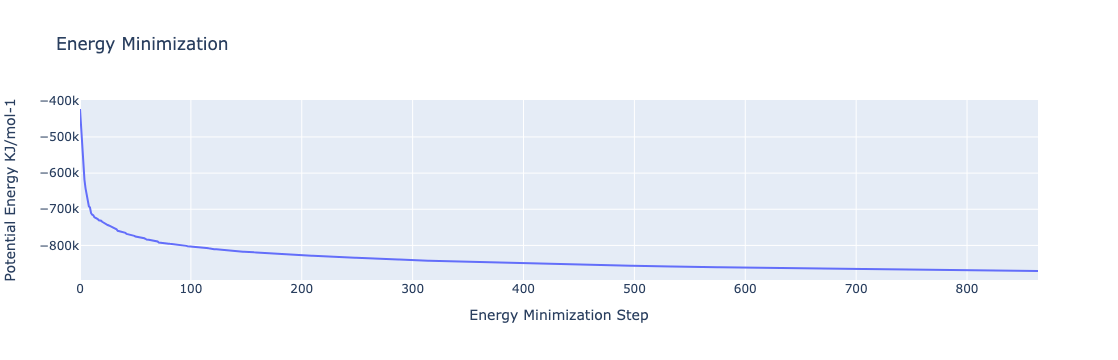

In [74]:
import plotly
import plotly.graph_objs as go

#Read data from file and filter energy values higher than 1000 Kj/mol^-1
with open(output_min_ene_xvg,'r') as energy_file:
    x,y = map(
        list,
        zip(*[
            (float(line.split()[0]),float(line.split()[1]))
            for line in energy_file 
            if not line.startswith(("#","@")) 
            if float(line.split()[1]) < 1000 
        ])
    )

plotly.offline.init_notebook_mode(connected=True)

fig = {
    "data": [go.Scatter(x=x, y=y)],
    "layout": go.Layout(title="Energy Minimization",
                        xaxis=dict(title = "Energy Minimization Step"),
                        yaxis=dict(title = "Potential Energy KJ/mol-1")
                       )
}

plotly.offline.iplot(fig)

<a id="npt"></a>
***
### Equilibrate the system (NPT)
Equilibrate the **protein system** in **NPT** ensemble (constant Number of particles, Pressure and Temperature).
- [Step 1](#eqNPTStep1): Creating portable binary run file for system equilibration
- [Step 2](#eqNPTStep2): Equilibrate the **protein system** with **NPT** ensemble.
- [Step 3](#eqNPTStep3): Checking **NPT Equilibration** results. Plotting **system pressure and density** by time during the **NPT equilibration** process.
***
**Building Blocks** used:
 - [Grompp](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.grompp) from **biobb_gromacs.gromacs.grompp** 
 - [Mdrun](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.mdrun) from **biobb_gromacs.gromacs.mdrun** 
 - [GMXEnergy](https://biobb-analysis.readthedocs.io/en/latest/gromacs.html#module-gromacs.gmx_energy) from **biobb_analysis.gromacs.gmx_energy** 
***

<a id="eqNPTStep1"></a>
#### Step 1: Creating portable binary run file for system equilibration (NPT)

The **npt** type of the **molecular dynamics parameters (mdp) property** contains the main default parameters to run an **NPT equilibration** with **protein restraints** (see [GROMACS mdp options](http://manual.gromacs.org/documentation/2018/user-guide/mdp-options.html)):

-  Define                   = -DPOSRES
-  integrator               = md
-  dt                       = 0.002
-  nsteps                   = 5000
-  pcoupl = Parrinello-Rahman
-  pcoupltype = isotropic
-  tau_p = 1.0
-  ref_p = 1.0
-  compressibility = 4.5e-5
-  refcoord_scaling = com
-  gen_vel = no

In this particular example, the default parameters will be used: **md** integrator algorithm, a **time step** of **2fs**, **5,000 equilibration steps** with the protein **heavy atoms restrained**, and a Parrinello-Rahman **pressure coupling** algorithm.

*Please note that for the sake of time this tutorial is only running 10ps of NPT equilibration, whereas in the [original example](http://www.mdtutorials.com/gmx/lysozyme/07_equil2.html) the simulated time was 100ps.*

In [88]:
# Grompp: Creating portable binary run file for NPT Equilibration
from biobb_gromacs.gromacs.grompp import grompp

# Create prop dict and inputs/outputs
input_mdp_eq = "inputs/md_eq_posre_charmm36m.mdp"
output_gppnpt_tpr = pdbCode+'_gppnpt.tpr'

prop = {
    'mdp': {
        'nsteps' : 50000
    },
    'gmx_lib' : cwd + '/inputs',
    'maxwarn' : 1
}

# Create and launch bb
grompp(input_gro_path=output_min_gro, 
       input_top_zip_path=output_genion_top_zip, 
       input_mdp_path=input_mdp_eq,
       output_tpr_path=output_gppnpt_tpr,  
       properties=prop)

2023-10-02 11:53:57,938 [MainThread  ] [INFO ]  Executing biobb_gromacs.gromacs.grompp Version: 4.1.0
2023-10-02 11:53:57,942 [MainThread  ] [INFO ]  Copy: 3RVT_min.gro to /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/09122201-d13c-40d5-abdd-6ba1ca25216f
2023-10-02 11:53:57,944 [MainThread  ] [INFO ]  Copy: inputs/md_eq_posre_charmm36m.mdp to /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/09122201-d13c-40d5-abdd-6ba1ca25216f
2023-10-02 11:53:57,949 [MainThread  ] [INFO ]  Extracting: /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/3RVT_genion_top.zip
2023-10-02 11:53:57,950 [MainThread  ] [INFO ]  to:
2023-10-02 11:53:57,950 [MainThread  ] [INFO ]  ['/Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/09122201-d13c-40d5-abdd-6ba1ca25216f/p2g.top', '/Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/09122201-d13c-40d5-

0

<a id="eqNPTStep2"></a>
#### Step 2: Running NPT equilibration

In [89]:
# Mdrun: Running NPT System Equilibration
from biobb_gromacs.gromacs.mdrun import mdrun

# Create prop dict and inputs/outputs
output_npt_trr = pdbCode+'_npt.trr'
output_npt_gro = pdbCode+'_npt.gro'
output_npt_edr = pdbCode+'_npt.edr'
output_npt_log = pdbCode+'_npt.log'
output_npt_cpt = pdbCode+'_npt.cpt'

# Create and launch bb
mdrun(input_tpr_path=output_gppnpt_tpr, 
      output_trr_path=output_npt_trr, 
      output_gro_path=output_npt_gro, 
      output_edr_path=output_npt_edr, 
      output_log_path=output_npt_log, 
      output_cpt_path=output_npt_cpt)

2023-10-02 11:54:03,542 [MainThread  ] [INFO ]  Executing biobb_gromacs.gromacs.mdrun Version: 4.1.0
2023-10-02 11:54:03,547 [MainThread  ] [INFO ]  Copy: 3RVT_gppnpt.tpr to /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/e31fda58-eb8f-4699-8627-23c58a704d4a
2023-10-02 11:54:03,547 [MainThread  ] [INFO ]  GROMACS Mdrun 20222 version detected
2023-10-02 11:54:03,548 [MainThread  ] [INFO ]  gmx -nobackup -nocopyright mdrun -o /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/e31fda58-eb8f-4699-8627-23c58a704d4a/3RVT_npt.trr -s /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/e31fda58-eb8f-4699-8627-23c58a704d4a/3RVT_gppnpt.tpr -c /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/e31fda58-eb8f-4699-8627-23c58a704d4a/3RVT_npt.gro -e /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/e31fda58-eb8f-4699-8627-23c58a704d4a/3RVT_n

0

<a id="eqNPTStep3"></a>
#### Step 3: Checking NPT Equilibration results
Checking **NPT Equilibration** results. Plotting **system pressure and density** by time during the **NPT equilibration** process. 

In [92]:
# GMXEnergy: Getting system pressure and density by time during NPT Equilibration  
from biobb_analysis.gromacs.gmx_energy import gmx_energy

# Create prop dict and inputs/outputs
output_npt_pd_xvg = pdbCode+'_npt_PD.xvg'
prop = {
    'terms':  ["Pressure","Density"]
}

# Create and launch bb
gmx_energy(input_energy_path=output_npt_edr, 
          output_xvg_path=output_npt_pd_xvg, 
          properties=prop)

2023-10-02 13:24:55,899 [MainThread  ] [INFO ]  Executing biobb_analysis.gromacs.gmx_energy Version: 4.1.0
2023-10-02 13:24:55,901 [MainThread  ] [INFO ]  Copy: /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/3RVT_npt.edr to /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/3f358c90-477d-487d-8d79-af9ab738c06a
2023-10-02 13:24:55,902 [MainThread  ] [INFO ]  gmx energy -f /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/3f358c90-477d-487d-8d79-af9ab738c06a/3RVT_npt.edr -o /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/3f358c90-477d-487d-8d79-af9ab738c06a/3RVT_npt_PD.xvg -xvg none < f9f95004-7a35-4c8a-99be-2f3a4f188ef3/instructions.in

2023-10-02 13:24:55,961 [MainThread  ] [INFO ]  Exit code 0

2023-10-02 13:24:55,962 [MainThread  ] [INFO ]  
Statistics over 50001 steps [ 0.0000 through 100.0000 ps ], 2 data sets
All statistics are over 501 points

En

0

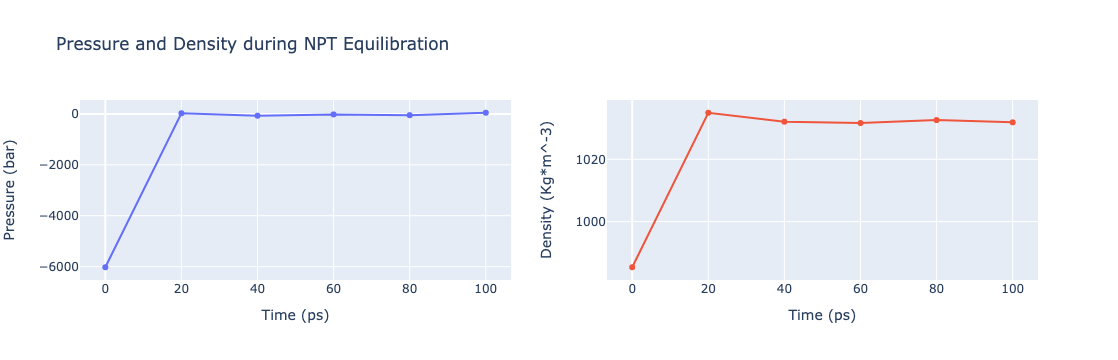

In [93]:
import plotly
from plotly import subplots
import plotly.graph_objs as go

# Read pressure and density data from file 
with open(output_npt_pd_xvg,'r') as pd_file:
    x,y,z = map(
        list,
        zip(*[
            (float(line.split()[0]),float(line.split()[1]),float(line.split()[2]))
            for line in pd_file 
            if not line.startswith(("#","@")) 
        ])
    )

plotly.offline.init_notebook_mode(connected=True)

trace1 = go.Scatter(
    x=x,y=y
)
trace2 = go.Scatter(
    x=x,y=z
)

fig = subplots.make_subplots(rows=1, cols=2, print_grid=False)

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)

fig['layout']['xaxis1'].update(title='Time (ps)')
fig['layout']['xaxis2'].update(title='Time (ps)')
fig['layout']['yaxis1'].update(title='Pressure (bar)')
fig['layout']['yaxis2'].update(title='Density (Kg*m^-3)')

fig['layout'].update(title='Pressure and Density during NPT Equilibration')
fig['layout'].update(showlegend=False)

plotly.offline.iplot(fig)

<a id="free"></a>
***
### Free Molecular Dynamics Simulation
Upon completion of the **two equilibration phases (NVT and NPT)**, the system is now well-equilibrated at the desired temperature and pressure. The **position restraints** can now be released. The last step of the **protein** MD setup is a short, **free MD simulation**, to ensure the robustness of the system. 
- [Step 1](#mdStep1): Creating portable binary run file to run a **free MD simulation**.
- [Step 2](#mdStep2): Run short MD simulation of the **protein system**.
- [Step 3](#mdStep3): Checking results for the final step of the setup process, the **free MD run**. Plotting **Root Mean Square deviation (RMSd)** and **Radius of Gyration (Rgyr)** by time during the **free MD run** step. 
***
**Building Blocks** used:
 - [Grompp](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.grompp) from **biobb_gromacs.gromacs.grompp** 
 - [Mdrun](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.mdrun) from **biobb_gromacs.gromacs.mdrun** 
 - [GMXRms](https://biobb-analysis.readthedocs.io/en/latest/gromacs.html#module-gromacs.gmx_rms) from **biobb_analysis.gromacs.gmx_rms** 
 - [GMXRgyr](https://biobb-analysis.readthedocs.io/en/latest/gromacs.html#module-gromacs.gmx_rgyr) from **biobb_analysis.gromacs.gmx_rgyr** 
***

<a id="mdStep1"></a>
#### Step 1: Creating portable binary run file to run a free MD simulation

The **free** type of the **molecular dynamics parameters (mdp) property** contains the main default parameters to run an **free MD simulation** (see [GROMACS mdp options](http://manual.gromacs.org/documentation/2018/user-guide/mdp-options.html)):

-  integrator               = md
-  dt                       = 0.002 (ps)
-  nsteps                   = 50000

In this particular example, the default parameters will be used: **md** integrator algorithm, a **time step** of **2fs**, and a total of **50,000 md steps** (100ps).

*Please note that for the sake of time this tutorial is only running 100ps of free MD, whereas in the [original example](http://www.mdtutorials.com/gmx/lysozyme/08_MD.html) the simulated time was 1ns (1000ps).*

In [104]:
# Grompp: Creating portable binary run file for mdrun
from biobb_gromacs.gromacs.grompp import grompp

# Create prop dict and inputs/outputs
input_mdp_md = "inputs/md_charmm36m.mdp"
output_gppmd_tpr = pdbCode+'_gppmd.tpr'

prop = {
    'mdp': {
        'nsteps' : 50000,
        'nstxout' : 1000
    },
    'gmx_lib' : cwd + '/inputs',
    'maxwarn' : 1
}

# Create and launch bb
grompp(input_gro_path=output_npt_gro, 
       input_top_zip_path=output_genion_top_zip, 
       input_mdp_path=input_mdp_md,
       output_tpr_path=output_gppmd_tpr, 
       input_cpt_path=output_npt_cpt, 
       properties=prop)

2023-10-02 14:40:06,525 [MainThread  ] [INFO ]  Executing biobb_gromacs.gromacs.grompp Version: 4.1.0
2023-10-02 14:40:06,529 [MainThread  ] [INFO ]  Copy: 3RVT_npt.gro to /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/3115c09e-0fac-41b1-bfd4-cd957a63acf9
2023-10-02 14:40:06,532 [MainThread  ] [INFO ]  Copy: 3RVT_npt.cpt to /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/3115c09e-0fac-41b1-bfd4-cd957a63acf9
2023-10-02 14:40:06,533 [MainThread  ] [INFO ]  Copy: inputs/md_charmm36m.mdp to /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/3115c09e-0fac-41b1-bfd4-cd957a63acf9
2023-10-02 14:40:06,538 [MainThread  ] [INFO ]  Extracting: /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/3RVT_genion_top.zip
2023-10-02 14:40:06,538 [MainThread  ] [INFO ]  to:
2023-10-02 14:40:06,539 [MainThread  ] [INFO ]  ['/Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_set

0

<a id="mdStep2"></a>
#### Step 2: Running short free MD simulation

In [105]:
# Mdrun: Running free dynamics
from biobb_gromacs.gromacs.mdrun import mdrun

# Create prop dict and inputs/outputs
output_md_trr = pdbCode+'_md.trr'
output_md_gro = pdbCode+'_md.gro'
output_md_edr = pdbCode+'_md.edr'
output_md_log = pdbCode+'_md.log'
output_md_cpt = pdbCode+'_md.cpt'

# Create and launch bb
mdrun(input_tpr_path=output_gppmd_tpr, 
      output_trr_path=output_md_trr, 
      output_gro_path=output_md_gro, 
      output_edr_path=output_md_edr, 
      output_log_path=output_md_log, 
      output_cpt_path=output_md_cpt)

2023-10-02 14:40:09,681 [MainThread  ] [INFO ]  Executing biobb_gromacs.gromacs.mdrun Version: 4.1.0
2023-10-02 14:40:09,684 [MainThread  ] [INFO ]  Copy: 3RVT_gppmd.tpr to /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/8814764c-314d-4018-ba25-c673fde1752d
2023-10-02 14:40:09,685 [MainThread  ] [INFO ]  GROMACS Mdrun 20222 version detected
2023-10-02 14:40:09,685 [MainThread  ] [INFO ]  gmx -nobackup -nocopyright mdrun -o /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/8814764c-314d-4018-ba25-c673fde1752d/3RVT_md.trr -s /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/8814764c-314d-4018-ba25-c673fde1752d/3RVT_gppmd.tpr -c /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/8814764c-314d-4018-ba25-c673fde1752d/3RVT_md.gro -e /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/8814764c-314d-4018-ba25-c673fde1752d/3RVT_md.ed

0

<a id="post"></a>
***
### Post-processing and Visualizing resulting 3D trajectory
Post-processing and Visualizing the **protein system** MD setup **resulting trajectory** using **NGL**
- [Step 1](#ppStep1): *Imaging* the resulting trajectory, **stripping out water molecules and ions** and **correcting periodicity issues**.
- [Step 2](#ppStep2): Generating a *dry* structure, **removing water molecules and ions** from the final snapshot of the MD setup pipeline.
- [Step 3](#ppStep3): Visualizing the *imaged* trajectory using the *dry* structure as a **topology**. 
***
**Building Blocks** used:
 - [GMXImage](https://biobb-analysis.readthedocs.io/en/latest/gromacs.html#module-gromacs.gmx_image) from **biobb_analysis.gromacs.gmx_image** 
 - [GMXTrjConvStr](https://biobb-analysis.readthedocs.io/en/latest/gromacs.html#module-gromacs.gmx_trjconv_str) from **biobb_analysis.gromacs.gmx_trjconv_str** 
***

<a id="ppStep1"></a>
#### Step 1: *Imaging* the resulting trajectory.
Stripping out **water molecules and ions** and **correcting periodicity issues**  

In [142]:
# GMXImage: "Imaging" the resulting trajectory
#           Removing water molecules and ions from the resulting structure
from biobb_analysis.gromacs.gmx_image import gmx_image

# Create prop dict and inputs/outputs
output_imaged_traj = pdbCode+'_imaged_traj.trr'
prop = {
    'center_selection':  'Protein',
    'output_selection': 'Protein',
    'pbc' : 'nojump',
}

# Create and launch bb
gmx_image(input_traj_path=output_md_trr,
         input_top_path=output_gppmin_tpr,
         output_traj_path=output_imaged_traj, 
          properties=prop)

2023-10-02 16:26:57,046 [MainThread  ] [INFO ]  Executing biobb_analysis.gromacs.gmx_image Version: 4.1.0
2023-10-02 16:26:57,060 [MainThread  ] [INFO ]  Copy: /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/3RVT_md.trr to /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/192c8be6-b056-4cd1-ac6e-70295176dbe4
2023-10-02 16:26:57,065 [MainThread  ] [INFO ]  Copy: /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/3RVT_gppmin.tpr to /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/192c8be6-b056-4cd1-ac6e-70295176dbe4
2023-10-02 16:26:57,066 [MainThread  ] [INFO ]  Copy: /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/397d5af4-deaa-47cf-b586-c250a6f57a40.stdin to /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/192c8be6-b056-4cd1-ac6e-70295176dbe4
2023-10-02 16:26:57,066 [MainThread  ] [INF

0

In [143]:
# GMXImage: "Imaging" the resulting trajectory
#           Removing water molecules and ions from the resulting structure
from biobb_analysis.gromacs.gmx_image import gmx_image

# Create prop dict and inputs/outputs
output_imaged_traj_rot = pdbCode+'_imaged_traj_rot.trr'
prop = {
    'center_selection':  'Protein',
    'output_selection': 'Protein',
    'fit' : 'rot+trans',
    'center' : True
}

# Create and launch bb
gmx_image(input_traj_path=output_imaged_traj,
         input_top_path=output_gppmd_tpr,
         output_traj_path=output_imaged_traj_rot, 
          properties=prop)

2023-10-02 16:26:57,973 [MainThread  ] [INFO ]  Executing biobb_analysis.gromacs.gmx_image Version: 4.1.0
2023-10-02 16:26:57,976 [MainThread  ] [INFO ]  Copy: /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/3RVT_imaged_traj.trr to /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/33882efd-fb79-4b8d-8397-e1d007902d19
2023-10-02 16:26:57,980 [MainThread  ] [INFO ]  Copy: /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/3RVT_gppmd.tpr to /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/33882efd-fb79-4b8d-8397-e1d007902d19
2023-10-02 16:26:57,981 [MainThread  ] [INFO ]  Copy: /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/c83d90e3-b53e-4696-a82d-bda3dbd3d58d.stdin to /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/33882efd-fb79-4b8d-8397-e1d007902d19
2023-10-02 16:26:57,981 [MainThread

0

<a id="ppStep2"></a>
#### Step 2: Generating the output *dry* structure.
**Removing water molecules and ions** from the resulting structure

In [144]:
# GMXTrjConvStr: Converting and/or manipulating a structure
#                Removing water molecules and ions from the resulting structure
#                The "dry" structure will be used as a topology to visualize 
#                the "imaged dry" trajectory generated in the previous step.
from biobb_analysis.gromacs.gmx_trjconv_str import gmx_trjconv_str

# Create prop dict and inputs/outputs
output_dry_gro = pdbCode+'_md_dry.gro'
prop = {
    'selection':  'Protein'
}

# Create and launch bb
gmx_trjconv_str(input_structure_path=output_md_gro,
         input_top_path=output_gppmd_tpr,
         output_str_path=output_dry_gro, 
          properties=prop)

2023-10-02 16:26:58,357 [MainThread  ] [INFO ]  Executing biobb_analysis.gromacs.gmx_trjconv_str Version: 4.1.0
2023-10-02 16:26:58,361 [MainThread  ] [INFO ]  Copy: /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/3RVT_md.gro to /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/129c7d38-257c-484f-8468-4e805ed7fde7
2023-10-02 16:26:58,364 [MainThread  ] [INFO ]  Copy: /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/3RVT_gppmd.tpr to /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/129c7d38-257c-484f-8468-4e805ed7fde7
2023-10-02 16:26:58,366 [MainThread  ] [INFO ]  Copy: /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/256c0288-7b65-4719-97cb-c2e6aa22fc6c.stdin to /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/129c7d38-257c-484f-8468-4e805ed7fde7
2023-10-02 16:26:58,367 [MainThread  ]

<a id="ppStep3"></a>
#### Step 3: Visualizing the generated dehydrated trajectory.
Using the **imaged trajectory** (output of the [Post-processing step 1](#ppStep1)) with the **dry structure** (output of the [Post-processing step 2](#ppStep2)) as a topology.

In [145]:
# Show trajectory
view = nglview.show_simpletraj(nglview.SimpletrajTrajectory(output_imaged_traj_rot, output_dry_gro), gui=True)
view

NGLWidget(max_frame=50)

<a id="mdStep3"></a>
#### Step 4: Checking free MD simulation results
Checking results for the final step of the setup process, the **free MD run**. Plotting **Root Mean Square deviation (RMSd)** and **Radius of Gyration (Rgyr)** by time during the **free MD run** step. **RMSd** against the **experimental structure** (input structure of the pipeline) and against the **minimized and equilibrated structure** (output structure of the NPT equilibration step).

In [150]:
# GMXRms: Computing Root Mean Square deviation to analyse structural stability 
#         RMSd against experimental structure (backbone atoms)   

from biobb_analysis.gromacs.gmx_rms import gmx_rms

# Create prop dict and inputs/outputs
output_rms_exp = pdbCode+'_rms_exp.xvg'
prop = {
    'selection':  'Backbone',
    #'selection': 'non-Water'
}

# Create and launch bb
gmx_rms(input_structure_path=output_gppmin_tpr,
         input_traj_path=output_imaged_traj_rot,
         output_xvg_path=output_rms_exp, 
          properties=prop)

2023-10-02 16:28:12,901 [MainThread  ] [INFO ]  Executing biobb_analysis.gromacs.gmx_rms Version: 4.1.0
2023-10-02 16:28:12,905 [MainThread  ] [INFO ]  Copy: /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/3RVT_gppmin.tpr to /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/b882df3a-1905-49c3-8641-732fbbd8f7a2
2023-10-02 16:28:12,908 [MainThread  ] [INFO ]  Copy: /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/3RVT_imaged_traj_rot.trr to /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/b882df3a-1905-49c3-8641-732fbbd8f7a2
2023-10-02 16:28:12,909 [MainThread  ] [INFO ]  Copy: /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/33c6821c-0b74-48b9-bb5b-739845b78762.stdin to /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/b882df3a-1905-49c3-8641-732fbbd8f7a2
2023-10-02 16:28:12,910 [MainThr

0

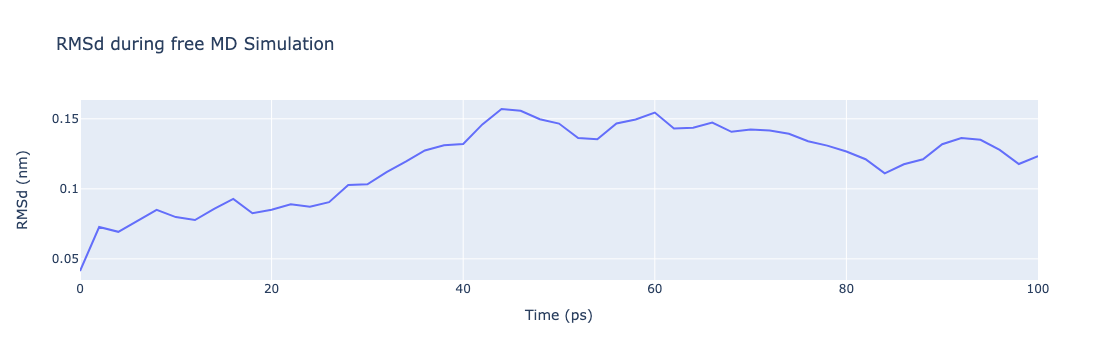

In [153]:
import plotly
import plotly.graph_objs as go

# Read RMS vs experimental structure data from file 
with open(output_rms_exp,'r') as rms_exp_file:
    x2,y2 = map(
        list,
        zip(*[
            (float(line.split()[0]),float(line.split()[1]))
            for line in rms_exp_file
            if not line.startswith(("#","@")) 
        ])
    )

trace = go.Scatter(
    x = x,
    y = y2,
    name = 'RMSd vs exp'
)

plotly.offline.init_notebook_mode(connected=True)

fig = {
    "data": trace,
    "layout": go.Layout(title="RMSd during free MD Simulation",
                        xaxis=dict(title = "Time (ps)"),
                        yaxis=dict(title = "RMSd (nm)")
                       )
}

plotly.offline.iplot(fig)


In [156]:
# GMXRgyr: Computing Radius of Gyration to measure the protein compactness during the free MD simulation 

from biobb_analysis.gromacs.gmx_rgyr import gmx_rgyr

# Create prop dict and inputs/outputs
output_rgyr = pdbCode+'_rgyr.xvg'
prop = {
    'selection':  'Backbone'
}

# Create and launch bb
gmx_rgyr(input_structure_path=output_gppmin_tpr,
         input_traj_path=output_imaged_traj_rot,
         output_xvg_path=output_rgyr, 
          properties=prop)

2023-10-02 16:30:12,263 [MainThread  ] [INFO ]  Executing biobb_analysis.gromacs.gmx_rgyr Version: 4.1.0
2023-10-02 16:30:12,266 [MainThread  ] [INFO ]  Copy: /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/3RVT_gppmin.tpr to /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/cb93be73-9d22-48cd-9bfb-2169a1844f08
2023-10-02 16:30:12,269 [MainThread  ] [INFO ]  Copy: /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/3RVT_imaged_traj_rot.trr to /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/cb93be73-9d22-48cd-9bfb-2169a1844f08
2023-10-02 16:30:12,270 [MainThread  ] [INFO ]  Copy: /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/d79f90bc-c970-4883-a832-13c5f1396a84.stdin to /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/cb93be73-9d22-48cd-9bfb-2169a1844f08
2023-10-02 16:30:12,271 [MainTh

0

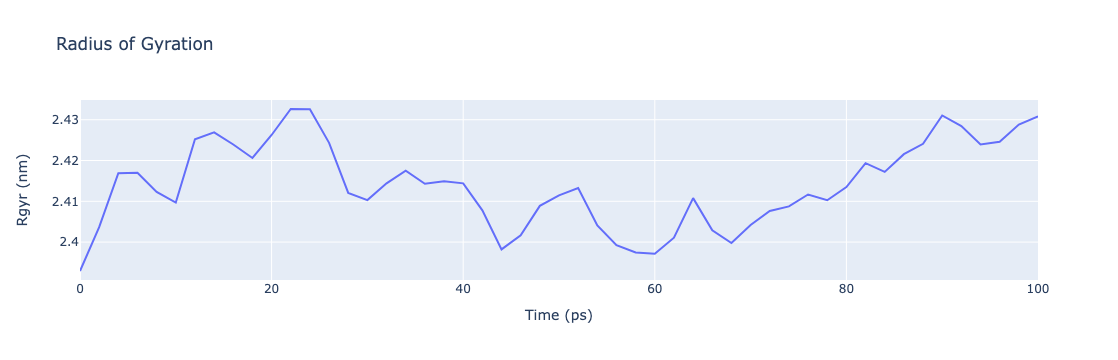

In [157]:
import plotly
import plotly.graph_objs as go

# Read Rgyr data from file 
with open(output_rgyr,'r') as rgyr_file:
    x,y = map(
        list,
        zip(*[
            (float(line.split()[0]),float(line.split()[1]))
            for line in rgyr_file 
            if not line.startswith(("#","@")) 
        ])
    )

plotly.offline.init_notebook_mode(connected=True)

fig = {
    "data": [go.Scatter(x=x, y=y)],
    "layout": go.Layout(title="Radius of Gyration",
                        xaxis=dict(title = "Time (ps)"),
                        yaxis=dict(title = "Rgyr (nm)")
                       )
}

plotly.offline.iplot(fig)

In [212]:
#r_26_27_28_29_30_31_32_50_51_52_91_92_93_94_95_96_239_240_241_242_243_244_245_246_267_268_269_313_314_315_316_317_318_319_320_321_322
loop_residues = [26,27,28,29,30,31,32,50,51,52,91,92,93,94,95,96,239,240,241,242,243,244,245,246,267,268,269,313,314,315,316,317,318,319,320,321,322]
ngl_loop_residues = ':' + ' '.join(str(x) for x in loop_residues)

view = nglview.show_structure_file(output_dry_gro, default_representation=False)
view.add_representation(repr_type='cartoon')
#view.add_representation(repr_type='ball+stick', selection=ngl_loop_residues, color='red')
view.add_representation(repr_type='ball+stick', selection="26 17", color='red')
view.center()
view._remote_call('setSize', target='Widget', args=['','600px'])
view

NGLWidget()

In [205]:
from biobb_gromacs.gromacs.make_ndx import make_ndx

# Create prop dict and inputs/outputs
loop_ndx = pdbCode+'_loop.ndx'

select_loop_residues = 'r ' + ' '.join(str(x) for x in loop_residues)

index_input = select_loop_residues + '\nname 10 Loop'

print(select_loop_residues)
print(index_input)

prop = { 
    'selection': index_input
}

# Create and launch bb
make_ndx(input_structure_path=output_dry_gro,
         output_ndx_path=loop_ndx,
         properties=prop)

r 26 27 28 29 30 31 32 50 51 52 91 92 93 94 95 96 239 240 241 242 243 244 245 246 267 268 269 313 314 315 316 317 318 319 320 321 322
r 26 27 28 29 30 31 32 50 51 52 91 92 93 94 95 96 239 240 241 242 243 244 245 246 267 268 269 313 314 315 316 317 318 319 320 321 322
name 10 Loop
2023-10-02 17:19:50,388 [MainThread  ] [INFO ]  Executing biobb_gromacs.gromacs.make_ndx Version: 4.1.0
2023-10-02 17:19:50,391 [MainThread  ] [INFO ]  Copy: 3RVT_md_dry.gro to /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/015374cf-4276-4c48-b70f-8c26bd0e6d4d
2023-10-02 17:19:50,392 [MainThread  ] [INFO ]  Copy: /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/809cc400-06e6-4d60-9256-36f20ad911ad.stdin to /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/015374cf-4276-4c48-b70f-8c26bd0e6d4d
2023-10-02 17:19:50,392 [MainThread  ] [INFO ]  GROMACS MakeNdx 20222 version detected
2023-10-02 17:19:50,393 [MainThr

0

In [208]:
from biobb_analysis.gromacs.gmx_cluster import gmx_cluster

output_pdb_cluster = pdbCode+"_clusters.pdb"

prop = {
    'fit_selection': 'Loop',
    'output_selection': 'System',
#    'method': 'gromos',
    'method' : 'jarvis-patrick',
    'cutoff' : 0.1,
    'nofit' : True
    #'remove_tmp' : False
}
gmx_cluster(input_structure_path=output_gppmin_tpr,
            input_traj_path=output_imaged_traj_rot,
            input_index_path=loop_ndx,
            output_pdb_path=output_pdb_cluster,
            properties=prop)

2023-10-02 17:23:35,322 [MainThread  ] [INFO ]  Executing biobb_analysis.gromacs.gmx_cluster Version: 4.1.0
2023-10-02 17:23:35,327 [MainThread  ] [INFO ]  Copy: /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/3RVT_gppmin.tpr to /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/55823374-a2ba-45f4-9302-a43a58ac1750
2023-10-02 17:23:35,330 [MainThread  ] [INFO ]  Copy: /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/3RVT_imaged_traj_rot.trr to /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/55823374-a2ba-45f4-9302-a43a58ac1750
2023-10-02 17:23:35,331 [MainThread  ] [INFO ]  Copy: /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/3RVT_loop.ndx to /Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/55823374-a2ba-45f4-9302-a43a58ac1750
2023-10-02 17:23:35,333 [MainThread  ] [INFO ]  Copy: /Us

0

In [209]:
view = nglview.show_structure_file(output_pdb_cluster, default_representation=False)
view.clear_representations()
view.add_representation(repr_type='cartoon', selection='all', color='modelindex')
view.center()
view._remote_call('setSize', target='Widget', args=['','600px'])
view

NGLWidget()

In [214]:
!python scripts/ImmunoPDB.py -i 3RVT.pdb -o 3RVT_ch.pdb --scheme c --rename --splitscfv

  File "/Users/hospital/BioBB/Antibody/BioBB/biobb_wf_md_setup/biobb_wf_md_setup/notebooks/scripts/ImmunoPDB.py", line 175
    print 'Warning: Numbering may be incorrect as a missing residue was detected in chain %s (around residue %d%s). Provide the seqres record to overcome this problem.'%(chain.id, chain.child_list[at].id[1], chain.child_list[at].id[2] )
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
SyntaxError: Missing parentheses in call to 'print'. Did you mean print(...)?


## Docking the generated structures with HADDOCK

In [ ]:
# copiar del workflow de biobb_wf_haddock

### Running HADDOCK3

In [ ]:
from biobb_haddock.haddock.common import read_cfg
from haddock.gear.config import load, save

In [39]:
final_cfg = load(haddock_config_path)
final_cfg['final_cfg']

{'run_dir': PosixPath('run1'),
 'mode': 'local',
 'ncores': 50,
 'postprocess': True,
 'clean': True,
 'molecules': [PosixPath('pdbs/4G6K_clean.pdb'),
  PosixPath('pdbs/4I1B_clean.pdb')],
 'topoaa.1': {},
 'rigidbody.1': {'ambig_fname': PosixPath('restraints/ambig-paratope-NMR-epitope.tbl'),
  'unambig_fname': PosixPath('restraints/antibody-unambig.tbl'),
  'sampling': 100},
 'caprieval.1': {'reference_fname': PosixPath('pdbs/4G6M_matched.pdb')},
 'seletop.1': {'select': 40},
 'flexref.1': {'tolerance': 5,
  'ambig_fname': PosixPath('restraints/ambig-paratope-NMR-epitope.tbl'),
  'unambig_fname': PosixPath('restraints/antibody-unambig.tbl')},
 'caprieval.2': {'reference_fname': PosixPath('pdbs/4G6M_matched.pdb')},
 'emref.1': {'tolerance': 5,
  'ambig_fname': PosixPath('restraints/ambig-paratope-NMR-epitope.tbl'),
  'unambig_fname': PosixPath('restraints/antibody-unambig.tbl')},
 'caprieval.3': {'reference_fname': PosixPath('pdbs/4G6M_matched.pdb')},
 'clustfcc.1': {'plot_matrix': True

In [21]:
save(load(wf_config)['final_cfg'], 'output_file_path.cfg')

In [36]:
from biobb_haddock.haddock.haddock3_run import haddock3_run

haddock_config_path        = f'{haddock_data}workflows/docking-antibody-antigen.cfg'
output_haddock_wf_data_zip = f'{out_path}wf.zip'  

haddock3_run(mol1_input_pdb_path  = ab_clean_pdb,
             mol2_input_pdb_path  = ag_clean_pdb,
             haddock_config_path        = haddock_config_path,
             output_haddock_wf_data_zip = output_haddock_wf_data_zip)

2025-05-05 10:38:18,057 [MainThread  ] [INFO ]  Module: biobb_haddock.haddock.haddock3_run Version: 5.0.0
2025-05-05 10:38:18,058 [MainThread  ] [INFO ]  /home/rchaves/repo/ab_design/biobb_wf_haddock/sandbox_8cb99d08-da81-4a4f-97e4-91f820d07e3d directory successfully created
2025-05-05 10:38:18,059 [MainThread  ] [INFO ]  Copy: ./data/antibody/HADDOCK3-antibody-antigen/pdbs/4G6K_clean.pdb to /home/rchaves/repo/ab_design/biobb_wf_haddock/sandbox_8cb99d08-da81-4a4f-97e4-91f820d07e3d
2025-05-05 10:38:18,059 [MainThread  ] [INFO ]  Copy: ./data/antibody/HADDOCK3-antibody-antigen/pdbs/4I1B_clean.pdb to /home/rchaves/repo/ab_design/biobb_wf_haddock/sandbox_8cb99d08-da81-4a4f-97e4-91f820d07e3d
2025-05-05 10:38:18,060 [MainThread  ] [INFO ]  Copy: ./data/antibody/HADDOCK3-antibody-antigen/workflows/docking-antibody-antigen.cfg to /home/rchaves/repo/ab_design/biobb_wf_haddock/sandbox_8cb99d08-da81-4a4f-97e4-91f820d07e3d
/home/rchaves/repo/ab_design/biobb_wf_haddock/sandbox_8cb99d08-da81-4a4f-97

KeyError: 'haddock_step_name'

### Analysis of results

## PMX

In [ ]:
# https://mmb.irbbarcelona.org/biobb/workflows/tutorials/biobb_wf_pmx_tutorial
# https://github.com/bioexcel/biobb_wf_pmx_tutorial

***
<a id="questions"></a>

## Questions & Comments

Questions, issues, suggestions and comments are really welcome!

* GitHub issues:
    * [https://github.com/bioexcel/biobb](https://github.com/bioexcel/biobb)

* BioExcel forum:
    * [https://ask.bioexcel.eu/c/BioExcel-Building-Blocks-library](https://ask.bioexcel.eu/c/BioExcel-Building-Blocks-library)
